In [1]:
from pathlib import Path
import datetime

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

# Functions

In [2]:
def double_lorentzian(x: np.ndarray, x0: float, x1: float, gamma: float) -> np.ndarray:
    """ Return double lorentzian dips at x0 and x1 with FWHM gamma"""
    lower_dip = 1 / np.pi * ((gamma / 2) / ((x - x0)**2 + (gamma / 2)**2))
    upper_dip = 1 / np.pi * ((gamma / 2) / ((x - x1)**2 + (gamma / 2)**2))
    return 1 - (lower_dip + upper_dip)

def save_data(folder: Path, filelabel: str, data: np.ndarray, timestamp: datetime.datetime):
    """ Save arrays to folder with unique filelabel """
    
    if not folder.exists():
        folder.mkdir()
    
    # Format timestamp
    filename = timestamp.strftime('%Y%m%d-%H%M-%S') + f"_{filelabel}.dat"
    
    # Create header string (match qudi-hira)
    header = f"Saved Data from the class pulsedODMR on {timestamp.strftime('%d.%m.%Y at %Hh%Mm%Ss')}.\n"
    header += '\nParameters:\n===========\n\n'
    header += '\nData:\n=====\n'
    header += "Freq(MHz)\tCounts"

    # Save to file
    np.savetxt(folder / filename, data, fmt='%.15e', delimiter='\t', header=header, comments="#")
    
def odmr_splitting_pattern(pattern: str, min_split: float, max_split: float, pixels: int) -> np.ndarray:
    """ Behavior of ODMR splitting """ 
    if pixels % 2 != 0:
        # Odd number of pixels
        num_points1 = pixels**2 // 2
        num_points2 = pixels**2 // 2 + 1
    else:
        # Even number of pixels
        num_points1 = num_points2 = pixels**2 // 2
        
    # Double check pixel number matches number of splittings
    assert num_points1 + num_points2 == pixels**2, f"{num_points1} + {num_points2} not equal to {pixels**2}"

    match pattern:
        case "linear":
            return np.linspace(min_split, max_split, pixels**2)
        case "linear_maxima":
            # Linear ODMR splitting around maxima
            return np.concatenate((
                np.linspace(min_split, max_split, num_points1), 
                np.linspace(max_split, min_split, num_points2)
            ))
        case "logarithmic_maxima":
            # Logarithmic ODMR splitting around maxima
            return np.concatenate((
                np.geomspace(min_split, max_split, num_points1), 
                np.geomspace(max_split, min_split, num_points2)
            ))
        case "double_dip":
            x = np.linspace(min_split, max_split, pixels**2)
            delta = max_split - min_split
            return double_lorentzian(x, x0=min_split + delta * 0.2, x1=min_split + delta * 0.8, gamma=delta/5)
        case "checkerboard":
            x = np.linspace(0.01, 1, pixels**2)
            return 4 + min_split + 4 * np.sin(pixels * 10 * x) * np.sin(pixels * x)
        case "moire":
            x = np.linspace(0.01, 1, pixels**2)
            k1 = pixels**2 * 0.4
            k2 = k1 * 0.9
            A = (k1 + k2) / 2
            B = (k1 - k2) / 2
            delta = max_split - min_split
            return min_split + delta/2 * (1 + np.sin(A * x) * np.cos(B * x))
        case _: raise ValueError("Incorrect value for behavior")

# Parameters

In [10]:
# Points per ODMR scan
num_points = 50

# (pixel x pixel) grid 
pixels = 32

# Zero field splitting
zfs = 2870 # MHz

# Peak width
gamma = 3 # MHz

# Gaussian noise strength
noise_factor = 0.01

# Measurement freq range (zfs +/- limit)
limit = 20 # MHz

# Minimum and maximum ODMR splitting
min_split = 0 # MHz
max_split = 10 # MHz

# Pattern of ODMR splitting
pattern = "linear"
odmr_splittings = odmr_splitting_pattern(pattern, min_split, max_split, pixels)

identifier = f"rasterodmr_{pattern}_noise_factor_{format(noise_factor, '.0e')}_{pixels}x{pixels}pixels"
save_path = Path("Data", "20230703_TestRasterODMR", "ODMRPixelScan")

# Frequency array
x = np.linspace(start=zfs-limit, stop=zfs+limit, num=num_points)

print(identifier)

rasterodmr_linear_noise_factor_1e-02_32x32pixels


# Generate data

In [11]:
timestamp = datetime.datetime.min
odmr_data = []

for idx, splitting in enumerate(odmr_splittings):
    # Lower and upper peaks
    x0 = zfs - splitting / 2
    x1 = zfs + splitting / 2
    y = double_lorentzian(x, x0=x0, x1=x1, gamma=gamma) + noise_factor * np.random.randn(num_points)

    odmr_data.append([x, y])
    
    # Save data with (row, col) of pixel
    row, col = idx // pixels, idx % pixels
    save_data(folder=save_path, filelabel=f"{identifier}_({row},{col})", data=np.array([x, y]).T, timestamp=timestamp)
    timestamp += datetime.timedelta(seconds=1)

# Plot data

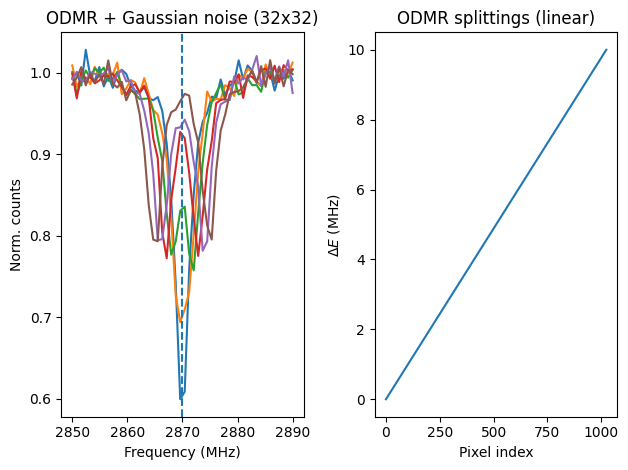

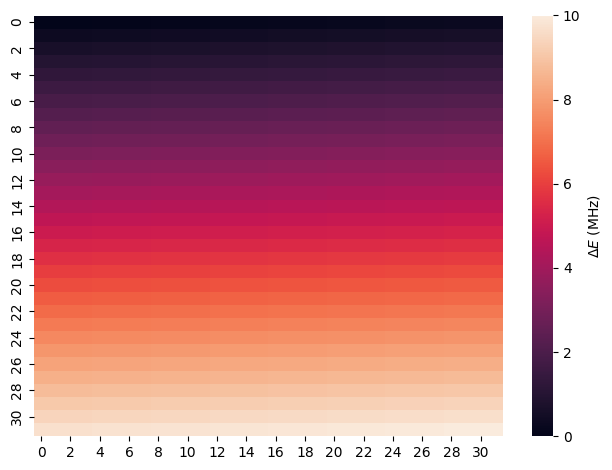

In [12]:
fig, (ax, ax1) = plt.subplots(ncols=2)

for odmr in odmr_data[::len(odmr_data)//5]:
    sns.lineplot(x=odmr[0], y=odmr[1], ax=ax)

ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Norm. counts")
ax.axvline(zfs, ls="--", label="ZFS")
ax.set_title(f"ODMR + Gaussian noise ({pixels}x{pixels})")

sns.lineplot(odmr_splittings, ax=ax1)
ax1.set_xlabel("Pixel index")
ax1.set_ylabel(r"$\Delta E$ (MHz)")
ax1.set_title(f"ODMR splittings ({pattern})")
fig.tight_layout()

fig2, ax2 = plt.subplots()
sns.heatmap(odmr_splittings.reshape(pixels, pixels), cbar_kws={"label": r"$\Delta E$ (MHz)"}, ax=ax2)
fig2.tight_layout()